In [1]:
from pynvml import *
nvmlInit()
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
handle = nvmlDeviceGetHandleByIndex(1)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory", info.total)
print("Free memory", info.free)
print("Used memory", info.used)

Total memory 17071734784
Free memory 17061249024
Used memory 10485760


In [2]:
# -*- coding: utf-8 -*-
"""
# @file name  : train_lenet.py
# @author     : tingsongyu
# @date       : 2019-09-07 10:08:00
# @brief      : 人民币分类模型训练
"""
"""
# @file name  : train_lenet_gpu_copy.py
# @modified by: greebear
# @date       : 2019-10-26 13:25:00
# @brief      : 猫狗分类模型训练
"""
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from matplotlib import pyplot as plt
from lenet import LeNet, MyNet
from DogCat_dataset import DogCatDataset


def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


set_seed()  # 设置随机种子

# 参数设置
MAX_EPOCH = 40
BATCH_SIZE = 512
LR = 1e-3
log_interval = 10
val_interval = 1

In [3]:
# ============================ step 1/5 数据 ============================

split_dir = os.path.join("..", "data", "cad_split")
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "valid")

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomApply([transforms.RandomCrop(200, padding=24, padding_mode='reflect')], p=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize(norm_mean, norm_std),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

# 构建MyDataset实例
train_data = DogCatDataset(data_dir=train_dir, transform=train_transform)
valid_data = DogCatDataset(data_dir=valid_dir, transform=valid_transform)

# 构建DataLoder
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=16)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, num_workers=16)

In [4]:
# ============================ step 2/5 模型 ============================

net = MyNet(classes=2)
net.initialize_weights()

In [5]:
net.to("cuda")

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [6]:
# ============================ step 3/5 损失函数 ============================
criterion = nn.CrossEntropyLoss()   

In [7]:
# ============================ step 4/5 优化器 ============================
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-1)                        # 选择优化器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

In [8]:
# inputs.to("cuda").device

In [9]:
from torchsummary import summary
summary(net, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]           2,368
       BatchNorm2d-2         [-1, 16, 512, 512]              32
            Conv2d-3         [-1, 32, 256, 256]           4,640
       BatchNorm2d-4         [-1, 32, 256, 256]              64
            Conv2d-5         [-1, 32, 256, 256]           9,248
       BatchNorm2d-6         [-1, 32, 256, 256]              64
            Conv2d-7         [-1, 64, 128, 128]          18,496
       BatchNorm2d-8         [-1, 64, 128, 128]             128
            Conv2d-9         [-1, 64, 128, 128]          36,928
      BatchNorm2d-10         [-1, 64, 128, 128]             128
           Conv2d-11          [-1, 128, 64, 64]          73,856
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]         147,584
      BatchNorm2d-14          [-1, 128,

In [10]:
valid_acc = list()

In [11]:
# ============================ step 5/5 训练 ============================
train_curve = list()
valid_curve = list()

for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    net.train()
    for i, data in enumerate(train_loader):
        # forward
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        outputs = net(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().cpu().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

    scheduler.step()  # 更新学习率

    # validate the model
    if (epoch+1) % val_interval == 0:

        correct_val = 0.
        total_val = 0.
        loss_val = 0.
        net.eval()
        with torch.no_grad():
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                inputs = inputs.to("cuda")
                labels = labels.to("cuda")
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).squeeze().sum().cpu().numpy()

                loss_val += loss.item()

            valid_curve.append(loss.item())
            valid_acc.append(correct_val / total_val)
            print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} 【Acc:{:.2%}】".format(
                epoch, MAX_EPOCH, j+1, len(valid_loader), loss_val, correct_val / total_val))
            

Training:Epoch[000/040] Iteration[010/040] Loss: 1.1178 Acc:54.02%
Training:Epoch[000/040] Iteration[020/040] Loss: 0.8828 Acc:55.31%
Training:Epoch[000/040] Iteration[030/040] Loss: 0.7864 Acc:56.40%
Training:Epoch[000/040] Iteration[040/040] Loss: 0.7714 Acc:57.56%
Valid:	 Epoch[000/040] Iteration[005/005] Loss: 3.3157 【Acc:58.48%】
Training:Epoch[001/040] Iteration[010/040] Loss: 0.6886 Acc:61.88%
Training:Epoch[001/040] Iteration[020/040] Loss: 0.6504 Acc:62.91%
Training:Epoch[001/040] Iteration[030/040] Loss: 0.6412 Acc:63.41%
Training:Epoch[001/040] Iteration[040/040] Loss: 0.6384 Acc:63.69%
Valid:	 Epoch[001/040] Iteration[005/005] Loss: 3.3017 【Acc:58.04%】
Training:Epoch[002/040] Iteration[010/040] Loss: 0.6425 Acc:64.77%
Training:Epoch[002/040] Iteration[020/040] Loss: 0.6134 Acc:65.83%
Training:Epoch[002/040] Iteration[030/040] Loss: 0.6023 Acc:66.45%
Training:Epoch[002/040] Iteration[040/040] Loss: 0.5837 Acc:66.97%
Valid:	 Epoch[002/040] Iteration[005/005] Loss: 3.8508 【Acc:

Training:Epoch[024/040] Iteration[030/040] Loss: 0.1490 Acc:95.38%
Training:Epoch[024/040] Iteration[040/040] Loss: 0.1386 Acc:95.52%
Valid:	 Epoch[024/040] Iteration[005/005] Loss: 0.8240 【Acc:94.28%】
Training:Epoch[025/040] Iteration[010/040] Loss: 0.1527 Acc:95.45%
Training:Epoch[025/040] Iteration[020/040] Loss: 0.1425 Acc:95.63%
Training:Epoch[025/040] Iteration[030/040] Loss: 0.1499 Acc:95.61%
Training:Epoch[025/040] Iteration[040/040] Loss: 0.1335 Acc:95.67%
Valid:	 Epoch[025/040] Iteration[005/005] Loss: 0.8042 【Acc:94.80%】
Training:Epoch[026/040] Iteration[010/040] Loss: 0.1426 Acc:95.66%
Training:Epoch[026/040] Iteration[020/040] Loss: 0.1384 Acc:95.83%
Training:Epoch[026/040] Iteration[030/040] Loss: 0.1407 Acc:95.84%
Training:Epoch[026/040] Iteration[040/040] Loss: 0.1457 Acc:95.69%
Valid:	 Epoch[026/040] Iteration[005/005] Loss: 0.8100 【Acc:94.52%】
Training:Epoch[027/040] Iteration[010/040] Loss: 0.1411 Acc:95.96%
Training:Epoch[027/040] Iteration[020/040] Loss: 0.1411 Acc

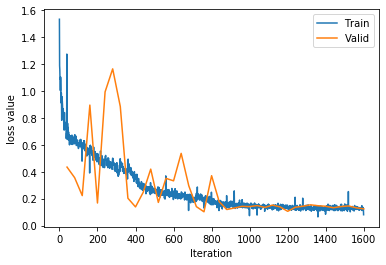

In [12]:
train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval # 由于valid中记录的是epochloss，需要对记录点进行转换到iterations
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()

In [13]:
max(valid_acc)

0.9508

In [14]:
torch.save(net, "./2")